# Case Study 1 - Design Single-Country Cat Bond for Samoa

In [1]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%load_ext autoreload
%autoreload 2
import exposures_alt as ex
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo

## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.05
upper_rp = 250

#define benchmark sharpe raito and risk free rate
target_sharpe = 0.5
rf_rate = 0.0

## Check Buffer Size and Basis Risk

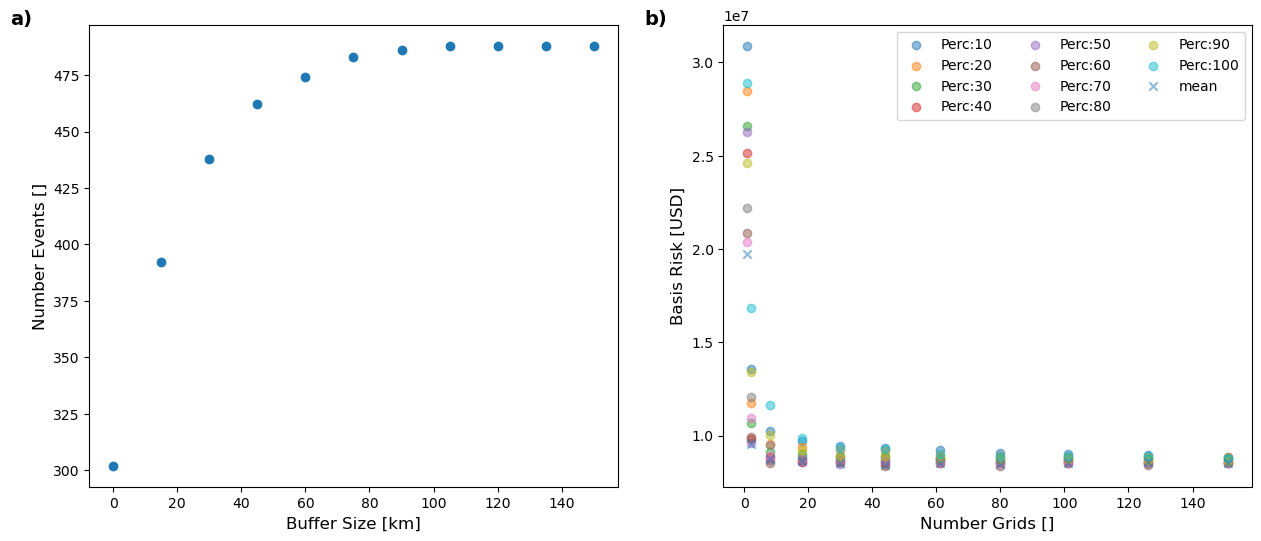

In [3]:
events_buffer = pd.read_excel("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/events_vs_buffer.xlsx")
br_grids_opt = pd.read_excel("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/rmse_grids_882.xlsx")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(events_buffer['Buffer Distance (km)'], events_buffer['Number Events'])
ax1.set_xlabel('Buffer Size [km]', fontsize=12)
ax1.set_ylabel('Number Events []', fontsize=12)

ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[10], alpha=0.5, label='Perc:10')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[20], alpha=0.5, label='Perc:20')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[30], alpha=0.5, label='Perc:30')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[40], alpha=0.5, label='Perc:40')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[50], alpha=0.5, label='Perc:50')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[60], alpha=0.5, label='Perc:60')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[70], alpha=0.5, label='Perc:70')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[80], alpha=0.5, label='Perc:80')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[90], alpha=0.5, label='Perc:90')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt[100], alpha=0.5, label='Perc:100')
ax2.scatter(br_grids_opt['Count grids'], br_grids_opt['mean'], alpha=0.5, marker='x', label='mean')
ax2.set_xlabel('Number Grids []', fontsize=12)
ax2.set_ylabel('Basis Risk [USD]', fontsize=12)
ax2.legend(loc='upper right', ncol=3)

panel_labels = ["a)", "b)"]
for i, ax in enumerate([ax1, ax2]):
    ax.annotate(panel_labels[i], 
                xy=(-0.15, 1),  # Position: top-left corner
                xycoords="axes fraction",  # Relative to axes
                fontsize=14, 
                fontweight="bold")
            
plt.show()

In [4]:
print(f"Maximum RMSE deviation: {1- br_grids_opt.iloc[:, :-1].min().min() / br_grids_opt.iloc[:, :-1].max().max()}")

Maximum RMSE deviation: 0.7286082917461976


In [5]:
# turn buffer test into latex table
buffer_dis_latex = events_buffer.to_latex(index=False, caption="Buffer distance", label="tab:cs1_buffer_test")
print(buffer_dis_latex)

\begin{table}
\caption{Buffer distance}
\label{tab:cs1_buffer_test}
\begin{tabular}{rr}
\toprule
Buffer Distance (km) & Number Events \\
\midrule
0 & 302 \\
15 & 392 \\
30 & 438 \\
45 & 462 \\
60 & 474 \\
75 & 483 \\
90 & 486 \\
105 & 488 \\
120 & 488 \\
135 & 488 \\
150 & 488 \\
\bottomrule
\end{tabular}
\end{table}



In [6]:
# turn subarea/statistics into latex table
br_grids_opt = br_grids_opt.round(0).astype(int)
br_grids_opt.iloc[:, :-1] = br_grids_opt.iloc[:, :-1].applymap(lambda x: f"{x:.2e}")
rmse_sub_latex = br_grids_opt.to_latex(index=False, caption="Rmse of basis risk", label="tab:cs1_br_sub")
print(rmse_sub_latex)

\begin{table}
\caption{Rmse of basis risk}
\label{tab:cs1_br_sub}
\begin{tabular}{lllllllllllr}
\toprule
10 & 20 & 30 & 40 & 50 & 60 & 70 & 80 & 90 & 100 & mean & Count grids \\
\midrule
3.09e+07 & 2.85e+07 & 2.66e+07 & 2.52e+07 & 2.63e+07 & 2.09e+07 & 2.04e+07 & 2.22e+07 & 2.46e+07 & 2.89e+07 & 1.97e+07 & 1 \\
1.36e+07 & 1.17e+07 & 1.07e+07 & 9.81e+06 & 9.59e+06 & 9.92e+06 & 1.09e+07 & 1.21e+07 & 1.34e+07 & 1.68e+07 & 9.54e+06 & 2 \\
1.03e+07 & 9.56e+06 & 9.10e+06 & 8.86e+06 & 8.70e+06 & 8.52e+06 & 8.91e+06 & 9.48e+06 & 1.00e+07 & 1.16e+07 & 8.77e+06 & 8 \\
9.70e+06 & 9.40e+06 & 9.04e+06 & 8.61e+06 & 8.61e+06 & 8.72e+06 & 8.74e+06 & 8.87e+06 & 9.22e+06 & 9.86e+06 & 8.62e+06 & 18 \\
9.46e+06 & 9.20e+06 & 8.90e+06 & 8.65e+06 & 8.50e+06 & 8.57e+06 & 8.71e+06 & 8.87e+06 & 8.87e+06 & 9.35e+06 & 8.55e+06 & 30 \\
9.32e+06 & 9.16e+06 & 8.89e+06 & 8.59e+06 & 8.50e+06 & 8.38e+06 & 8.67e+06 & 8.80e+06 & 8.91e+06 & 9.26e+06 & 8.44e+06 & 44 \\
9.22e+06 & 8.93e+06 & 8.81e+06 & 8.72e+06 & 8.50e+06 &

C:\Users\Kai\AppData\Local\Temp\ipykernel_26668\924704079.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  br_grids_opt.iloc[:, :-1] = br_grids_opt.iloc[:, :-1].applymap(lambda x: f"{x:.2e}")


### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


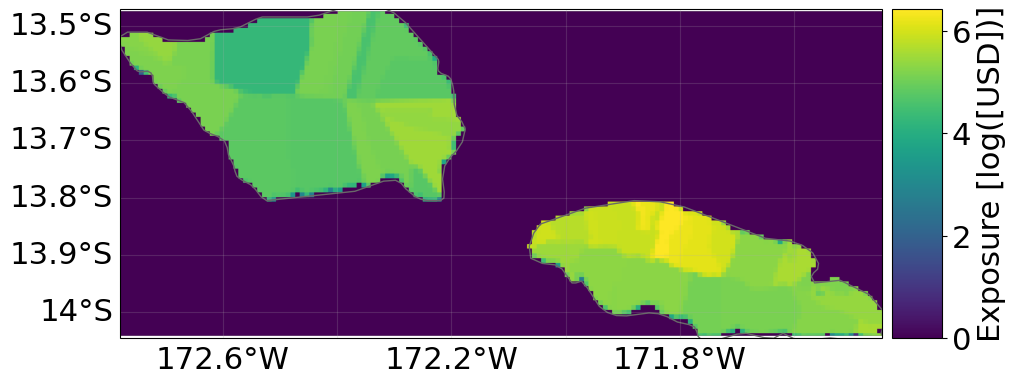

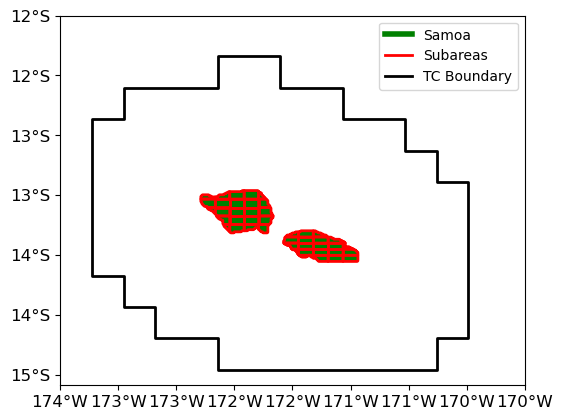

Number of tracks in SP basin: 3002


In [7]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, grid_specs=[5,5], buffer_distance_km=105, res_exp=30, min_pol_size=1000, 
                                                                                         buffer_grid_size=1, load_fls=True, 
                                                                                         file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/Data/cty_data"))

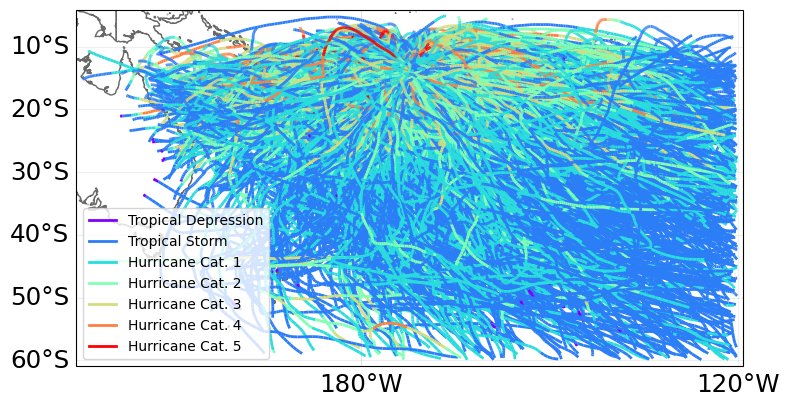

In [8]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot(figsize=(8, 6))
ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\impact.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


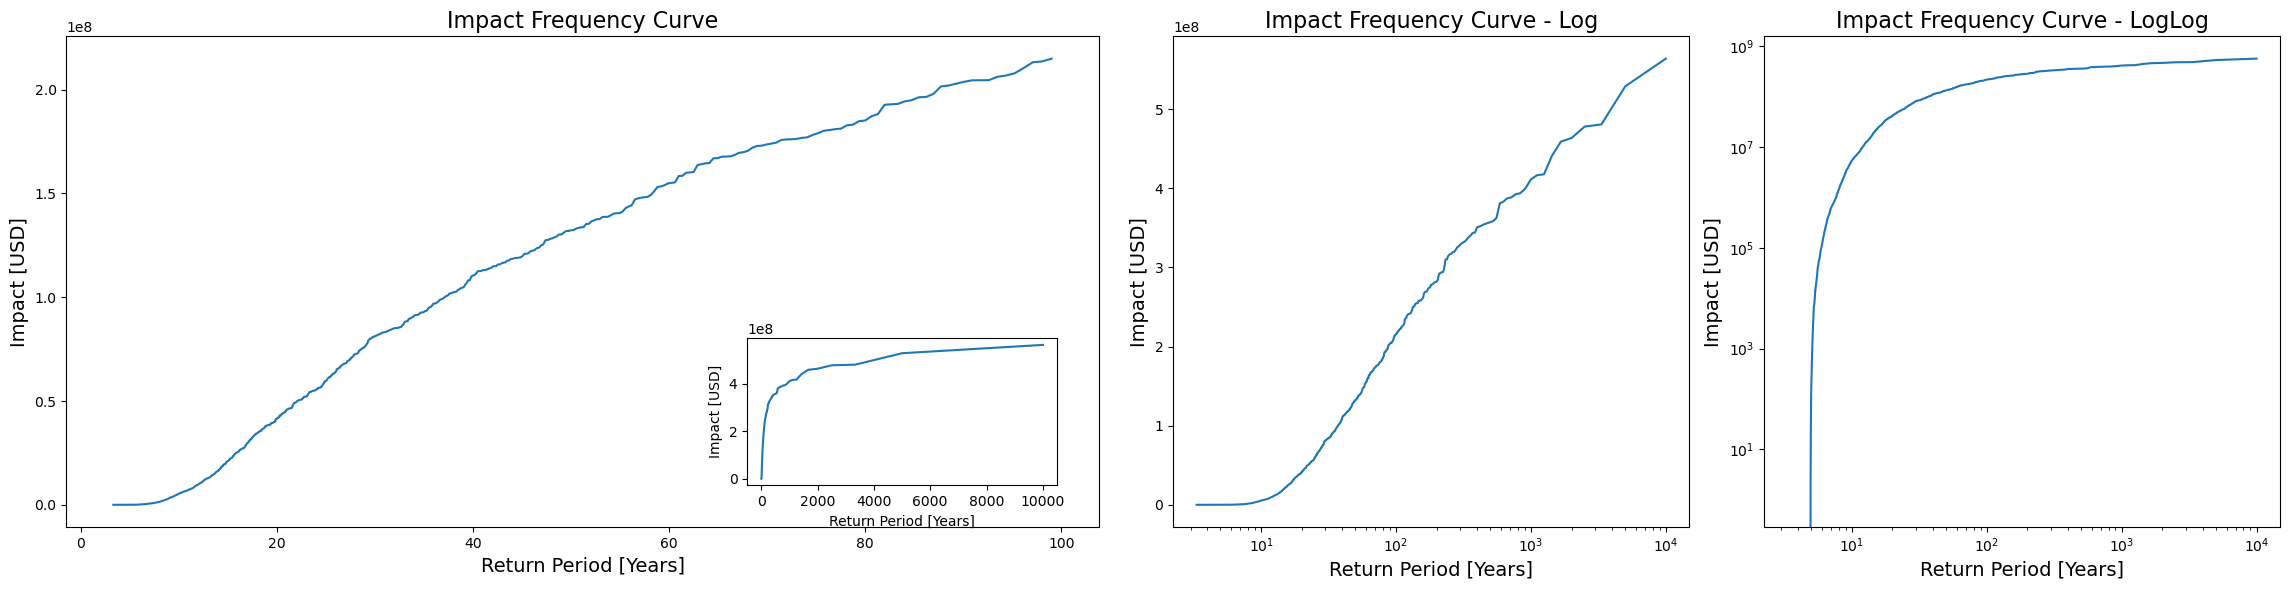

In [9]:
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=lower_share, exposure=exp)

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
1. Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using a quantile or the mean across hazard centroid located in each grid cell.
2. Add year for each event.

In [10]:
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat=60) 

Calculate Statistics per subarea and illustrate with a plot for two areas

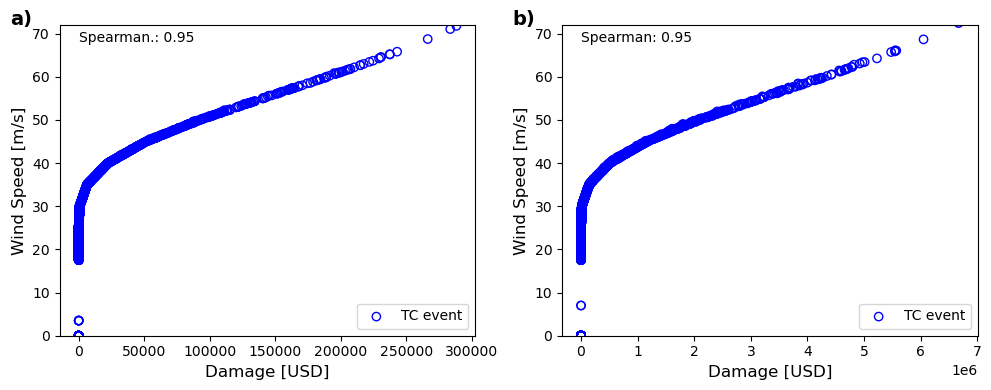

In [11]:
from scipy.stats import spearmanr

corr_a, pval = spearmanr(imp_admin_evt['A'], int_grid['A'])
corr_b, pval = spearmanr(imp_admin_evt['B'], int_grid['B'])
 
min_prot = snom.init_nominal(impact=imp, exposure=exp, prot_rp=25, print_nom=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(imp_admin_evt['A'], int_grid['A'], marker='o', edgecolor='blue', facecolor='none', label='TC event')
ax1.set_xlabel("Damage [USD]", fontsize=12)
ax1.set_ylabel("Wind Speed [m/s]", fontsize=12)
ax1.text(0, 68, f'Spearman.: {round(corr_a, 2)}', fontsize = 10)
ax1.set_ylim(0,72)
ax1.legend(loc='lower right')
           
ax2.scatter(imp_admin_evt['B'], int_grid['B'], marker='o', edgecolor='blue', facecolor='none', label='TC event')
ax2.set_xlabel("Damage [USD]", fontsize=12)
ax2.set_ylabel("Wind Speed [m/s]", fontsize=12)
ax2.text(0, 68, f'Spearman: {round(corr_b, 2)}', fontsize = 10)
ax2.set_ylim(0,72)
ax2.legend(loc='lower right')

panel_labels = ["a)", "b)"]
for i, ax in enumerate([ax1, ax2]):
    ax.annotate(panel_labels[i], 
                xy=(-0.12, 1),  
                xycoords="axes fraction",  
                fontsize=14, 
                fontweight="bold")
    
# Show both plots
plt.tight_layout()
plt.show()


In [12]:
for key in imp_admin_evt:
    print(key, spearmanr(imp_admin_evt[key], int_grid[key]))

A SignificanceResult(statistic=0.9457560788119166, pvalue=0.0)
B SignificanceResult(statistic=0.9512052816600686, pvalue=0.0)
C SignificanceResult(statistic=0.9513912392978603, pvalue=0.0)
D SignificanceResult(statistic=0.9490769646719452, pvalue=0.0)
E SignificanceResult(statistic=0.9493108453424906, pvalue=0.0)
F SignificanceResult(statistic=0.9524282033736277, pvalue=0.0)
G SignificanceResult(statistic=0.9523655054407429, pvalue=0.0)
H SignificanceResult(statistic=0.9521351594770556, pvalue=0.0)
I SignificanceResult(statistic=0.9513550304114285, pvalue=0.0)
J SignificanceResult(statistic=0.9508665228838572, pvalue=0.0)
K SignificanceResult(statistic=0.9521770952203978, pvalue=0.0)
L SignificanceResult(statistic=0.9510424924118741, pvalue=0.0)
M SignificanceResult(statistic=0.9503732307269261, pvalue=0.0)
N SignificanceResult(statistic=0.9468898965764366, pvalue=0.0)
O SignificanceResult(statistic=0.951386300695717, pvalue=0.0)
P SignificanceResult(statistic=0.9508755592868087, pvalu

#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [13]:
#define nominal
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=upper_rp)

The principal of the cat bond is: 316652842.906 [USD]
Principal as share of GDP: 0.364


### Perform optimization
Optmizie payout function using linear payout inbetween a minimung triggering and a maximum wind speed. Wind speeds equal or higher than maximum wind speed result in the payout of the full principle. <br>
Wind speeds are optimized for each grid cell.

In [14]:
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt)
print("Min_thresh: ", optimized_step1.min(), optimized_step1.max())
print("Max_thresh: ", optimized_step2.min(), optimized_step2.max())

{0: (38.84903189186165, 71.9072259247855), 1: (38.8030735948625, 72.79028509620984), 2: (38.80926634185321, 73.52946146002067), 3: (38.76441316261719, 73.29799706051489), 4: (39.01213424741521, 71.94336201277099), 5: (39.027452505222286, 72.4559092665277), 6: (38.83337321111701, 73.33414687555754), 7: (38.73905028286887, 73.68034710274027), 8: (38.676722584293906, 73.20302023506619), 9: (39.38882328240376, 72.0463743247383), 10: (39.19917073180827, 72.39548863794207), 11: (38.99941782298439, 73.20201927821458), 12: (38.93354230177565, 72.85219122462094), 13: (38.809422152444704, 72.75573810941583), 14: (39.568538004309005, 71.69567653878752), 15: (39.4047645568255, 72.263581976576), 16: (39.336339085661805, 72.33457806684382), 17: (39.224442187755045, 72.16028268454725), 18: (39.88522640612839, 71.21495444786065), 19: (39.8410145013228, 71.79865668969703), 20: (39.678460444369215, 71.74023610105353), 21: (39.75304818308857, 78.30882510429895), 22: (39.946153518658164, 78.56900030305566

### Assess payout vs damage for each event
1. Create a payout vs damage matrix per event
2. Plot payout vs damage on 1:1 scale

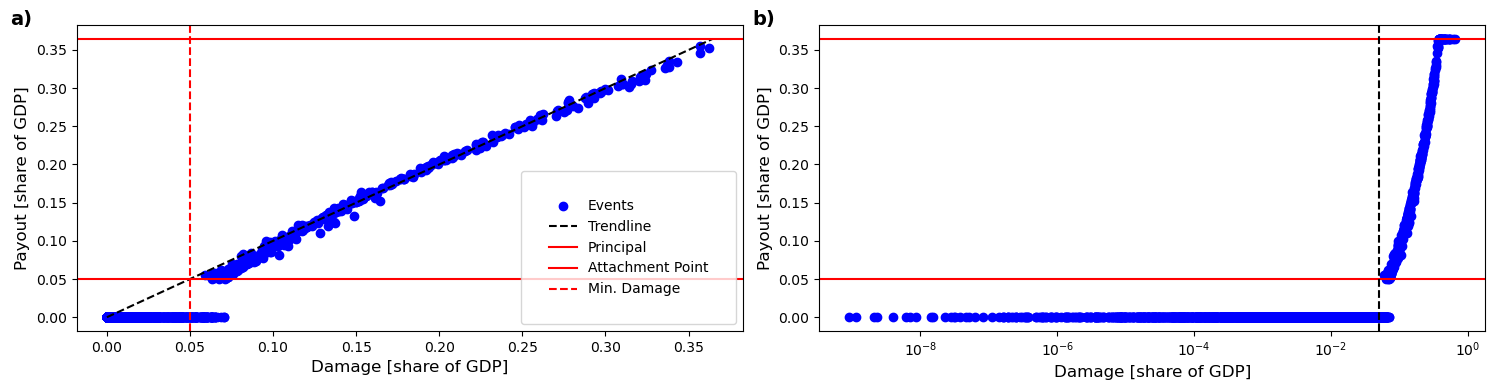

In [15]:
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_step1, optimized_step2, int_grid, nominal, imp_admin_evt, imp_per_event, exp)

In [16]:
min_pay = lower_share * exp.gdf['value'].sum()
count = ((pay_dam_df['pay'] == 0) & (pay_dam_df['damage'] >= min_pay)).sum()

print(f"Number of rows where 'damage' is not 0: {(pay_dam_df['damage'] >= min_pay).sum()}")
print(f"Number of rows where 'pay' is not 0: {(pay_dam_df['pay'] > 0).sum()}")
print(f"Share of rows where 'pay' is 0 and 'damage' is not 0: {count/(pay_dam_df['damage'] != 0).sum()}")
print(f"Share of rows where 'pay' is not 0 and 'damage' is not 0: {(pay_dam_df['pay'] != 0).sum() / (pay_dam_df['damage'] != 0).sum()}")
print(f"Number of events: {len(pay_dam_df['damage'])}")

Number of rows where 'damage' is not 0: 488
Number of rows where 'pay' is not 0: 412
Share of rows where 'pay' is 0 and 'damage' is not 0: 0.1557377049180328
Share of rows where 'pay' is not 0 and 'damage' is not 0: 0.8442622950819673
Number of events: 3002


In [17]:
corr, pval = spearmanr(pay_dam_df['pay'], pay_dam_df['damage'])
print("Spearman's correlation coefficient:", corr)

Spearman's correlation coefficient: 0.9309103162217508


### Calculate expected loss and attachment probability
1. Set annual probaility for hazard event
2. Simulate cat bond and calculate the expected loss as well as the annual attachment probability.

In [18]:
exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)

Expected Loss = 0.019004737520213345
Attachment Probability = 0.0367769976596456


### Calculate premiums using:
1. IBRD multiplier model
2. Benchmark sharpe ratio
3. Linear regression model of Chatoro et al. 2022

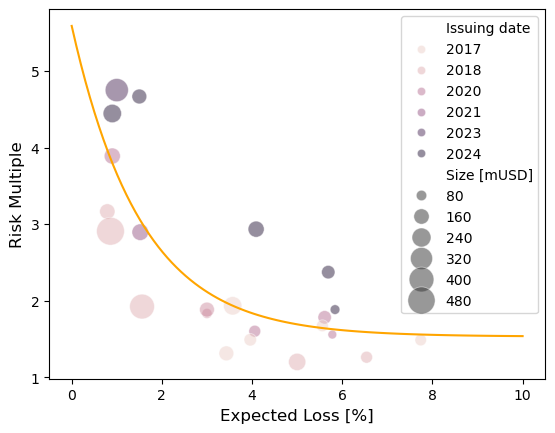

The premium based on past IBRD bonds is 5.167%, 16362589.0USD, 1.883%
The premium based on the regression model from Chatoro et al. 2022 is 8.731%, 27646905.0USD, 3.182%
The premium based on required sharpe ration of 0.5 is 8.101%, 25651157.0USD, 2.952%


In [20]:
params_ibrd = prib.init_prem_ibrd(file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
a, k, b = params_ibrd
tot_exp = exp.gdf['value'].sum()

premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100
premium_sharpe = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%, {round(premium_ibrd*nominal,0)}USD, {round(premium_ibrd*nominal/tot_exp*100,3)}%')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%, {round(premium_regression*nominal,0)}USD, {round(premium_regression*nominal/tot_exp*100,3)}%')
print(f'The premium based on required sharpe ration of {target_sharpe} is {round(premium_sharpe*100, 3)}%, {round(premium_sharpe*nominal,0)}USD, {round(premium_sharpe*nominal/tot_exp*100,3)}%')

## Simulate CAT bonds

In [41]:
bond_metrics_sng_ibrd, returns_sng_ibrd = sb.init_bond_simulation(pay_dam_df, premium_ibrd, rf_rate, nominal) 
bond_metrics_sng_regression, returns_sng_regression = sb.init_bond_simulation(pay_dam_df, premium_regression, rf_rate, nominal) 
bond_metrics_sng_required, returns_sng_required = sb.init_bond_simulation(pay_dam_df, premium_sharpe, rf_rate, nominal) 

In [65]:
#derive insurance metrics per pricing approach
print(bond_metrics_sng_ibrd['Total Premiums']/bond_metrics_sng_ibrd['Summed Payments'])
print(bond_metrics_sng_regression['Total Premiums']/bond_metrics_sng_regression['Summed Payments'])
print(bond_metrics_sng_required['Total Premiums']/bond_metrics_sng_required['Summed Payments'])

0    2.604553
dtype: float64
0    4.389096
dtype: float64
0    3.987517
dtype: float64


## Perform cat bond simulation using different nominals

In [44]:
#define nominals
prot_share_arr = np.arange(0.05, 0.61, 0.05) #protected share of total exposure
arr_nominal = []

for prot_share in prot_share_arr:
    nominal_prem = snom.init_nominal(impact=imp, exposure=exp, prot_share=prot_share, print_nom=False)
    arr_nominal.append(nominal_prem)

print('Nominals calculated')

#optimize payout per grid for each nominal
optimized_xs_nom = {}
optimized_ys_nom = {}
result_nom = {}
pay_dam_df_nom = {}
exp_loss_ann_nom = {}
es_metrics_nom = {}
att_prob_nom = {}
premium_ibrd_nom = {}
premium_regression_nom = {}
premium_simulation_required_nom = {}
returns_required_nom = {}
premium_simulation_ibrd_nom = {}
returns_ibrd_nom = {}
premium_simulation_regression_nom = {}
returns_regression_nom = {}
ann_losses_nom = {}
premium_required_nom =  {}

for nom in arr_nominal:
    nom_str = str(round(nom,0))
    result_nom[nom_str], optimized_xs_nom[nom_str], optimized_ys_nom[nom_str] = apo.init_alt_optimization(int_grid, nom, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=False)

    pay_dam_df_nom[nom_str] = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_xs_nom[nom_str], optimized_ys_nom[nom_str], int_grid, nom, imp_admin_evt)
    
    exp_loss_ann_nom[nom_str], att_prob_nom[nom_str], ann_losses_nom[nom_str], es_metrics_nom[nom_str] = sb.init_exp_loss_att_prob_simulation(pay_dam_df_nom[nom_str], nom, print_prob=False)

    premium_ibrd_nom[nom_str] = prib.monoExp(exp_loss_ann_nom[nom_str] * 100, a, k, b) * exp_loss_ann_nom[nom_str]
    premium_regression_nom[nom_str] = cp.calc_premium_regression(exp_loss_ann_nom[nom_str] * 100) / 100
    premium_required_nom[nom_str] = sb.init_prem_sharpe_ratio(ann_losses_nom[nom_str], rf_rate, target_sharpe)

    premium_simulation_ibrd_nom[nom_str], returns_ibrd_nom[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_ibrd_nom[nom_str], rf_rate, nom) 
    premium_simulation_regression_nom[nom_str], returns_regression_nom[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_regression_nom[nom_str], rf_rate, nom) 
    premium_simulation_required_nom[nom_str], returns_required_nom[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_required_nom[nom_str], rf_rate, nom)
    

Nominals calculated


Plot coverage, expected loss, attachment probabilty and premiums in relation to nominal/principal

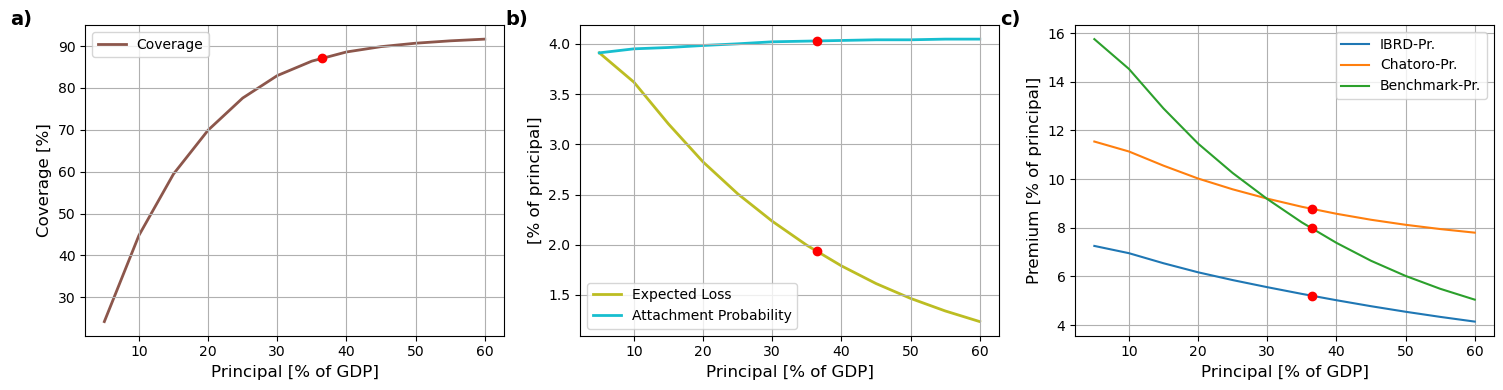

In [ ]:
coverage_nom = []
basis_risk_nom = []
tot_pay_nom = []
tot_pay = []
tot_pay_gdp = []
std_nom = []
multi_pay_prem_ibrd = []
multi_pay_prem_regression = []
multi_pay_prem_required = []
x_cur = 0.364

for nom_it in arr_nominal:
    nom_str = str(round(nom_it,0))
    coverage_nom.append(premium_simulation_ibrd_nom[nom_str]['Coverage'])
    tot_pay.append((premium_simulation_ibrd_nom[nom_str]['Summed Payments']))
    multi_pay_prem_ibrd.append((premium_simulation_ibrd_nom[nom_str]['Total Premiums']/premium_simulation_required_nom[nom_str]['Summed Payments']))
    multi_pay_prem_regression.append((premium_simulation_regression_nom[nom_str]['Total Premiums']/premium_simulation_required_nom[nom_str]['Summed Payments']))
    multi_pay_prem_required.append((premium_simulation_required_nom[nom_str]['Total Premiums']/premium_simulation_required_nom[nom_str]['Summed Payments']))
    tot_pay_nom.append((premium_simulation_ibrd_nom[nom_str]['Average Payments'])/(nom_it))
    tot_pay_gdp.append((premium_simulation_ibrd_nom[nom_str]['Average Payments'])/tot_exp)
    #std = np.std(ann_losses[nom_str])
    #std_nom.append(std)

premium_ibrd_arr = np.array(fct.get_all_values(premium_ibrd_nom))
premium_regression_arr = np.array(fct.get_all_values(premium_regression_nom))
premium_required_arr = np.array(fct.get_all_values(premium_required_nom))

exp_loss_arr = np.array(fct.get_all_values(exp_loss_ann_nom))
att_prob_arr = np.array(fct.get_all_values(att_prob_nom))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

color = 'tab:brown'
ax1.plot(np.array(prot_share_arr) * 100, np.array(coverage_nom) * 100, lw=2, color=color, label='Coverage', zorder=1)
ax1.scatter(x_cur * 100, bond_metrics_sng_ibrd['Coverage'][0] * 100, color='red', marker='o', zorder=2)
ax1.set_xlabel('Principal [% of GDP]', fontsize=12)
ax1.set_ylabel('Coverage [%]', fontsize=12)

ax1.legend(loc='upper left', ncol=1)

color = 'tab:olive'
ax2.plot(np.array(prot_share_arr) * 100, exp_loss_arr * 100, lw=2, color=color, label='Expected Loss', zorder=1)
ax2.set_xlabel('Principal [% of GDP]', fontsize=12)
ax2.set_ylabel('[% of principal]', fontsize=12)

color = 'tab:cyan'
ax2.plot(np.array(prot_share_arr) * 100, att_prob_arr * 100, lw=2, color=color, label='Attachment Probability', zorder=1)
ax2.scatter(x_cur * 100, att_prob * 100, color='red', marker='o', zorder=2)
ax2.scatter(x_cur * 100, exp_loss_ann * 100, color='red', marker='o', zorder=2)
ax2.legend()

ax3.plot(np.array(prot_share_arr) * 100, np.array(list(premium_ibrd_nom.values())) * 100, label='IBRD-Pr.')
ax3.plot(np.array(prot_share_arr) * 100, np.array(list(premium_regression_nom.values())) * 100, label='Chatoro-Pr.')
ax3.plot(np.array(prot_share_arr) * 100, np.array(list(premium_required_nom.values())) * 100, label='Benchmark-Pr.')
ax3.scatter(x_cur * 100, premium_ibrd * 100, color='red', marker='o', zorder=2)
ax3.scatter(x_cur * 100, premium_regression * 100, color='red', marker='o', zorder=2)
ax3.scatter(x_cur * 100, premium_sharpe * 100, color='red', marker='o', zorder=2)
ax3.set_xlabel('Principal [% of GDP]', fontsize=12)
ax3.set_ylabel('Premium [% of principal]', fontsize=12)
ax3.legend(loc='upper right')


panel_labels = ["a)", "b)", "c)"]
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.annotate(panel_labels[i], 
                xy=(-0.18, 1),  # Position: top-left corner
                xycoords="axes fraction",  # Relative to axes
                fontsize=14, 
                fontweight="bold")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
plt.show()



Plot premiums and insurance multiples in realation to coverage

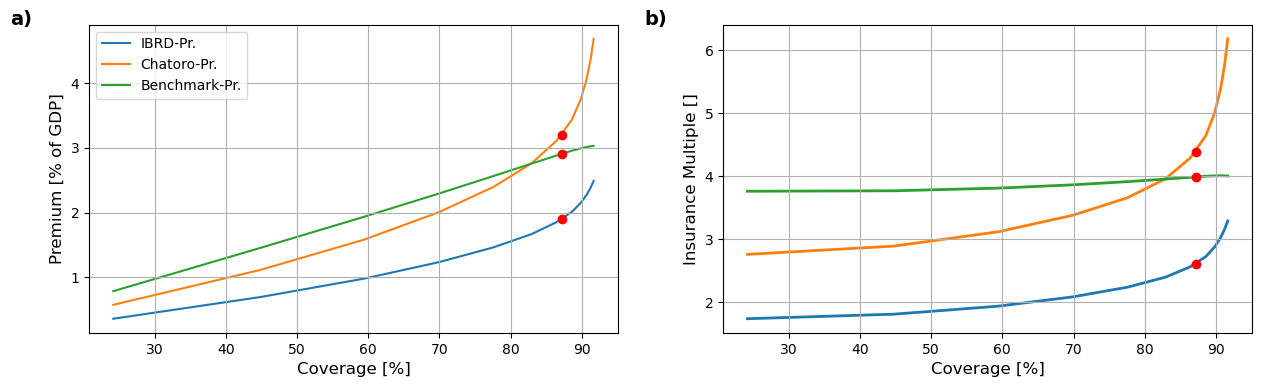

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(np.array(coverage_nom) * 100, premium_ibrd_arr*arr_nominal/tot_exp * 100, label='IBRD-Pr.', zorder=1)
ax1.plot(np.array(coverage_nom) * 100, premium_regression_arr*arr_nominal/tot_exp * 100, label='Chatoro-Pr.', zorder=1)
ax1.plot(np.array(coverage_nom) * 100, premium_required_arr*arr_nominal/tot_exp * 100, label='Benchmark-Pr.', zorder=1)
ax1.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, premium_ibrd*nominal/tot_exp * 100, color='red', marker='o', zorder=2)
ax1.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, premium_regression*nominal/tot_exp * 100, color='red', marker='o', zorder=2)
ax1.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, premium_sharpe*nominal/tot_exp * 100, color='red', marker='o', zorder=2)
ax1.set_xlabel('Coverage [%]', fontsize=12)
ax1.set_ylabel('Premium [% of GDP]', fontsize=12)
ax1.legend()

color = 'tab:red'
ax2.set_xlabel('Coverage [%]', fontsize=12)  
ax2.set_ylabel('Insurance Multiple []', fontsize=12)  
ax2.plot(np.array(coverage_nom) * 100, multi_pay_prem_ibrd, lw=2, label='PM: IBRD', zorder=1)
ax2.plot(np.array(coverage_nom) * 100, multi_pay_prem_regression, lw=2, label='PM: Regr.', zorder=1)
ax2.plot(np.array(coverage_nom) * 100, multi_pay_prem_required, lw=2, label='PM: Requ.', zorder=1)
ax2.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, bond_metrics_sng_ibrd['Total Premiums']/bond_metrics_sng_ibrd['Summed Payments'], color='red', marker='o', zorder=2)
ax2.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, bond_metrics_sng_regression['Total Premiums']/bond_metrics_sng_ibrd['Summed Payments'], color='red', marker='o', zorder=2)
ax2.scatter(bond_metrics_sng_ibrd['Coverage'][0] * 100, bond_metrics_sng_required['Total Premiums']/bond_metrics_sng_ibrd['Summed Payments'], color='red', marker='o', zorder=2)
 
#ax2.legend(loc='upper left')
panel_labels = ["a)", "b)"]
for i, ax in enumerate([ax1, ax2]):
    ax.annotate(panel_labels[i], 
                xy=(-0.15, 1), 
                xycoords="axes fraction",  
                fontsize=14, 
                fontweight="bold")
ax1.grid(True)
ax2.grid(True)
plt.show()

Plot mean payout and damage as well as occurences of damages/payouts per damage level

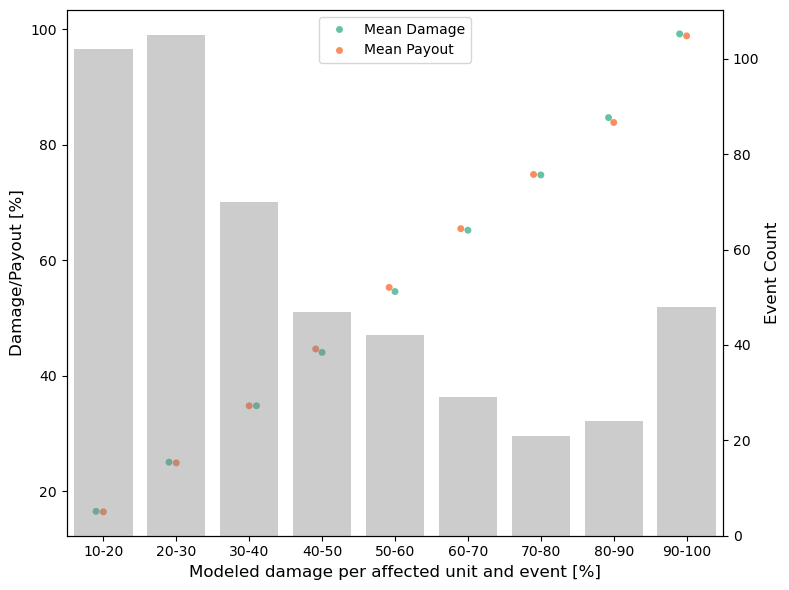

In [50]:
fct.plot_bin_dam_pay(pay_dam_df, nominal)